# Transfer Learning of Deep Neural Networks using CNN models
**Notebook 2 of 2**

In our previous tutorials, we explored various machine learning and deep learning algorithms trained for specific tasks. Each model had to be rebuilt from scratch when data or features changed. The concept of transfer learning improves on this by utilizing existing knowledge solve related but essentially new problems. In other words, we use what has been learned in one setting to improve generalization in another setting.<br>
In this tutorial, we will initially use the dogs vs cats dataset from Kaggle at the following link: [dogs vs cats](https://www.kaggle.com/c/dogs-vs-cats/data) which is an archive containing 25,000 images of dogs and cats. In the second case, we will do tranfer learning using the VGG-16 pre-trained model created by the University of Oxford.<br>

Comment: consider explaining the plan on what is going to be done with these images in this training.
Comment: define transfer learning above

## Learning Objectives

Average time to complete: 75min

By the end of this tutorial you should be able to:
* Apply notions from DNN and CNN.

Comment: avoid using abbreviations in the objectives; include the full name and put the abbreviations in parentheses.
  
* Learn how to implement the benefits of transfer learning
* Understand the inner workings of CNN models and transfer learning for fine tuning.
* Explore and analyze two transfer learning use cases: 1) Image classification with raw data, 2) Image classification using a pre-trained model

## What you will need for this tutorial

* See the [introduction document](https://uottawa-it-research-teaching.github.io/machinelearning/) for general requirements and how Jupyter notebooks work.
* This notebooks runs best on a server with GPU and 8GB RAM.  The Alliance server provide Nvidia V100 and A100 GPUs which work fine.
* We'll need Pandas for convenient data handling. It's a very powerful Python package that can read CSV and Excel files. It also has very good data manipulation capabilities which come in use for data cleaning.
* Keras / Tensorflow
* We will use scikit learn as our machine learning package.
* numpy 
* seaborn 
* matplotlib
* requests
* ipywidgets
* The data files that should have come with this notebook.

## RDM best practices

Good data handling for machine learning begins with good Research Data Managment (RDM). The quality of your source data will impact the outcome of your results, just like the reproducibility of your results will depend on the quality of your data sources, in addition to how you organize the data so that other people (and machines!) can understand and reuse it. 

We also need to respect a few research data management best practices along the way, these best practices are recommended by the [Digital Research Alliance of Canada](https://zenodo.org/records/4000989).

SAVE YOUR RAW DATA IN ORIGINAL FORMAT
* Don't overwrite your original data with a cleaned version.
* Protect your original data by locking them or making them read-only.
* Refer to this original data if things go wrong (as they often do).

BACKUP YOUR DATA
* Use the 3-2-1 rule: Save three copies of your data, on two different storage mediums, and one copy off site. The off site storage can be OneDrive or Google drive or whatever your institution provides.
* We are using Open Data, so it does not contain any personally identifiable data or data that needs to be restricted or protected in any way. However, if your data contains confidential information, it is important to take steps to restrict access and encrypt your data.

There are a few more RDM best practices that will help you in your project management, and we will highlight them at the beginning of each tutorial. 

Let's first check to see that we have access to the GPU

In [2]:
!rocm-smi



========================================= ROCm System Management Interface =========================================
=================================================== Concise Info ===================================================
Device  Node  IDs              Temp    Power  Partitions          SCLK    MCLK     Fan  Perf  PwrCap  VRAM%  GPU%  
              (DID,     GUID)  (Edge)  (Avg)  (Mem, Compute, ID)                                                   
0       2     0x740f,   63484  32.0°C  43.0W  N/A, N/A, 0         800Mhz  1600Mhz  0%   auto  300.0W  0%     0%    
1       3     0x740f,   42924  35.0°C  43.0W  N/A, N/A, 0         800Mhz  1600Mhz  0%   auto  300.0W  0%     0%    
=============================================== End of ROCm SMI Log ================================================


In the cell below, we are disabling warnings that can slow down the performance of the GPU. This is just some housekeeping for the execution of the code.

In [3]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

Add the libraries to our notebook

In [4]:
import glob
import numpy as np
import matplotlib.pyplot as plt
#from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
import shutil
np.random.seed(42)

%matplotlib inline

In [5]:
import keras
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.models import Sequential
from keras import optimizers

Next we check to see what compute resources we have access to as well as naming.  This is useful if we want to use some devices for higher compute needs such as Graphic Processing Units (GPU) shown as /device:GPU:0 or lower compute needs such as CPUs shown as /device:CPU:0

In [6]:
import tensorflow as tf
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7605808514205777890
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 67050143744
locality {
  bus_id: 1
  links {
    link {
      device_id: 1
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 9740822391387961764
physical_device_desc: "device: 0, name: AMD Instinct MI210, pci bus id: 0000:23:00.0"
xla_global_id: 416903419
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 67050143744
locality {
  bus_id: 2
  numa_node: 1
  links {
    link {
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 10529834370410550696
physical_device_desc: "device: 1, name: AMD Instinct MI210, pci bus id: 0000:e3:00.0"
xla_global_id: 2144165316
]


# Image Classification with a relatively small dataset

Working with images, especially in AI models, is very resource intense. Transfer learning reduces compute demands, so you can build smaller, more focused datasets and get results quickly. However, you must still ensure data quality and proper preprocessing, as poor data can undermine the benefits-even with powerful pre-trained models.  The next section Building Dataset is the first part of managing the limited compute resources and then Preparing Dataset involves code to prepare the reduced dataset for transfer learning.

### Building Dataset


Let's have a look at the cats vs dogs dataset and prepare the dataset we want to work with.


In [7]:
files = glob.glob('./train/*')

cat_files = [fn for fn in files if 'cat' in fn]
dog_files = [fn for fn in files if 'dog' in fn]
len(cat_files), len(dog_files)

(12500, 12500)

Let’s build our smaller dataset, so that we have 350 images for training, 150 images for validation, and 150 images for our test dataset


In [8]:
cat_train = np.random.choice(cat_files, size=350, replace=False)
dog_train = np.random.choice(dog_files, size=350, replace=False)
cat_files = list(set(cat_files) - set(cat_train))
dog_files = list(set(dog_files) - set(dog_train))

cat_val = np.random.choice(cat_files, size=150, replace=False)
dog_val = np.random.choice(dog_files, size=150, replace=False)
cat_files = list(set(cat_files) - set(cat_val))
dog_files = list(set(dog_files) - set(dog_val))

cat_test = np.random.choice(cat_files, size=150, replace=False)
dog_test = np.random.choice(dog_files, size=150, replace=False)

print('Cat datasets:', cat_train.shape, cat_val.shape, cat_test.shape)
print('Dog datasets:', dog_train.shape, dog_val.shape, dog_test.shape)

Cat datasets: (350,) (150,) (150,)
Dog datasets: (350,) (150,) (150,)


At the end, we save randomly selected images in 3 separate folders: training_data, validation_data, test_data.


In [9]:
train_dir = './training_data'
val_dir = './validation_data'
test_dir = './test_data'

train_files = np.concatenate([cat_train, dog_train])
validate_files = np.concatenate([cat_val, dog_val])
test_files = np.concatenate([cat_test, dog_test])

os.mkdir(train_dir) if not os.path.isdir(train_dir) else None
os.mkdir(val_dir) if not os.path.isdir(val_dir) else None
os.mkdir(test_dir) if not os.path.isdir(test_dir) else None

for fn in train_files:
    shutil.copy(fn, train_dir)

for fn in validate_files:
    shutil.copy(fn, val_dir)
    
for fn in test_files:
    shutil.copy(fn, test_dir)

### Preparing Dataset

The following code prepares the datasets for doing the transfer learning. The following code loads and processes images from training and validation directories, resizes them to 150x150 pixels, converts them to arrays, extracts labels from filenames, and prints the shapes of the resulting datasets.
* Find all the files in the training_data folder
* Load and resize each image file to the specified dimensions using load_img and img_to_array.  This is done in RAM
* Convert the list of images to a Numpy array train_imgs
* Extract the labels or classes from the file names and stores them in train_labels.


The resulting train_imgs and train_Labels can be used for training the CNN model whereby train_imgs contains the image data, and train_labels contains the corresponding labels or classes.

In [10]:
IMG_DIM = (150, 150)

train_files = glob.glob('./training_data/*')
train_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in train_files]
train_imgs = np.array(train_imgs)
train_labels = [fn.split('/')[2].split('.')[0].strip() for fn in train_files]

validation_files = glob.glob('./validation_data/*')
validation_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in validation_files]
validation_imgs = np.array(validation_imgs)
validation_labels = [fn.split('/')[2].split('.')[0].strip() for fn in validation_files]

print('Train dataset shape:', train_imgs.shape, 
      '\tValidation dataset shape:', validation_imgs.shape)

Train dataset shape: (700, 150, 150, 3) 	Validation dataset shape: (2573, 150, 150, 3)


We have 350 training images each for dogs and cats, making a total of 700 images. For validation, we have 150 images each for dogs and cats, totaling 300 images. Each image is 150x150 pixels and has three color channels: red, green, and blue (RGB). So, each image has dimensions of 150x150x3.


Scaling images ensures compatibility with pre-trained models, enhances computational efficiency, and improves the model's ability to learn from new data.

Next, scale each image with pixel values between (0, 255) to values between (0, 1) because deep learning work very well with small input values

(150, 150, 3)


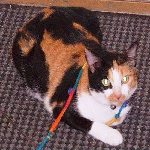

In [11]:
train_imgs_scaled = train_imgs.astype('float32')
validation_imgs_scaled  = validation_imgs.astype('float32')
train_imgs_scaled /= 255
validation_imgs_scaled /= 255

print(train_imgs[0].shape)
array_to_img(train_imgs[0])

Output shows one of the sample images from our training dataset

Keras is an open-source, high-level deep learning library that provides a user-friendly Python interface for building and training neural networks, and is widely used for tasks like image processing.

For compute efficiency purposes, it is best to configure Keras parameters and also encode our text class labels into numeric values. Numbers require less memory and processing power to analyze.

In [16]:
batch_size = 30                      #Indicates the total number of images passed to the model per iteration
num_classes = 2
epochs = 30                          # Indicates number of iterations
input_shape = (150, 150, 3)          # Shape of the images

# encode text category labels
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(train_labels)
train_labels_enc = le.transform(train_labels)

validation_labels_enc = le.transform(validation_labels)

print(train_labels[14:20], train_labels_enc[14:20])

['cat', 'cat', 'cat', 'cat', 'cat', 'cat'] [0 0 0 0 0 0]


We can see that our encoding scheme assigns the number 0 to the cat labels and 1 to the dog labels. We are now ready to build our first CNN-based deep learning model.

### Simple CNN Model built from scratch 


We will start by building a basic CNN model with three convolutional layers, coupled with max pooling for auto-extraction of features from our images and also downsampling the output convolution feature maps.

<b>Max pooling</b> is a method used in computer vision to make images smaller by looking at small regions of an image and picking only the largest value feature from each region. This helps keep the most important information while reducing the size of the data the computer has to handle.
<b>Downsampling</b> means making an image smaller by reducing the number of pixels, which lowers the resolution and makes the file easier and faster for computers to process. 

Let's take a look at the major building blocks of our basic CNN model...<br>
* Conv2D Layer: Adds a 2D convolutional layer with 16 filters.
* Filter Size: Each filter is 3x3 pixels.
* Activation Function: ReLU is applied to the output of this layer.
* Input Shape: Each image is 150x150 pixels with a depth of 3.
* Max Pooling: Helps the CNN focus on important features and discard less relevant information, improving feature representation.
* ReLU Efficiency: ReLU is the most computationally efficient activation function, allowing the model to capture complex relationships.
* Enhanced Feature Capture: Improves the CNN's ability to capture features during training.


In [17]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.models import Sequential
from keras import optimizers

# Open an instance for the model
model = Sequential()

# Conv2D add a 2D convolutional layer with 16 filters.   
# Each filter is 3x3 pixels in size.  The activation funtion ReLu is applied to the output of this layer. 
# Input shape is the shape of each image - Here it is 150 pixles x 150 pixels x depth of 3.
# We apply max pooling to the layer helps the CNN focus on the most salient features and discard less relevant
# information, leading to better feature representation.
# ReLu is the most computaitonally efficient activation function.  Recall from the DNN workshop that this 
# function allows a model to capture more complex relationships.  
# This enhances the CNN's ability to capture features during the training.

model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', 
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# These are the final layers of the model.  Flatten reshapes the output from the previous layer into a 1D
# vector.
# Dense add a fully connected layer with 512 neurons and a ReLu activation function.
# The second Dense add the final fully connected layer with 1 neuron and a sigmoid activation function. This
# layer produces the binary output (0, 1), (cat, dog) for the classification task
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(),
              metrics=['accuracy'])

model.summary()



'''
Layer (type)                 Output Shape              Param #   
=================================================================
conv2d_1 (Conv2D)            (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        9280      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 36992)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               18940416  
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513       
=================================================================
Total params: 19,024,513
Trainable params: 19,024,513
Non-trainable params: 0
_________________________________________________________________
'''


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │         9,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,024,513 (72.57 MB)

 Trainable params: 19,024,513 (72.57 MB)

 Non-trainable params: 0 (0.00 B)

'\nLayer (type)                 Output Shape              Param #   \n=================================================================\nconv2d_1 (Conv2D)            (None, 148, 148, 16)      448       \n_________________________________________________________________\nmax_pooling2d_1 (MaxPooling2 (None, 74, 74, 16)        0         \n_________________________________________________________________\nconv2d_2 (Conv2D)            (None, 72, 72, 64)        9280      \n_________________________________________________________________\nmax_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         \n_________________________________________________________________\nconv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     \n_________________________________________________________________\nmax_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         \n_________________________________________________________________\nflatten_1 (Flatten)          (None, 36992)             0   

<b>model.summary()</b> helps us track the input data as it passes through the various layers of the CNN. An output shape of (None, 148, 148, 16) means the layer produced an output tensor (vector) of variable batch size, height and width of 148 pixels and 16 feature maps. The later layer has 128 features of abstraction which means that the CNN model is using 128 features to classify an image passed to it.


We use a batch_size of 30.  If our training data has a total of 350 samples, which indicates that there will be a total of 12 steps where the model looks at a small group of data (called a batch) and updates itself (iterations per epoch). We train the model for a total of 30 epochs and validate it consequently on our validation set of 150 images.<br>
An epoch is when the complete dataset has passed through the network once, that is, all the iterations are completed based on data batches.

The line below lauched the training of the model

In [18]:
history = model.fit(x=train_imgs_scaled, y=train_labels_enc,
                    validation_data=(validation_imgs_scaled, validation_labels_enc),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1)

Epoch 1/30


I0000 00:00:1746710434.999403 3297976 service.cc:146] XLA service 0x780320009e20 initialized for platform ROCM (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746710434.999431 3297976 service.cc:154]   StreamExecutor device (0): AMD Instinct MI210, AMDGPU ISA version: gfx90a:sramecc+:xnack-
I0000 00:00:1746710434.999440 3297976 service.cc:154]   StreamExecutor device (1): AMD Instinct MI210, AMDGPU ISA version: gfx90a:sramecc+:xnack-


Params set by AI: DeviceGroupedConvFwdMultipleABD_Xdl_CShuffle<256, 128, 128, 16, Default, 32, 32, 2, 2, 1, 1, 4, 1, 1, 1>
Params set by AI: DeviceGroupedConvFwdMultipleABD_Xdl_CShuffle<256, 128, 64, 16, Default, 32, 32, 2, 1, 4, 4, 4, 1, 1, 1>
Params set by AI: DeviceGroupedConvFwdMultipleABD_Xdl_CShuffle<256, 128, 64, 16, OddC, 32, 32, 2, 1, 4, 4, 4, 1, 1, 1>
11/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5028 - loss: 1.1018 

I0000 00:00:1746710443.626064 3297976 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


21/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4997 - loss: 0.9784Params set by AI: DeviceGroupedConvFwdMultipleABD_Xdl_CShuffle<256, 128, 128, 16, OddC, 32, 32, 2, 2, 1, 1, 4, 1, 1, 1>
Params set by AI: DeviceGroupedConvFwdMultipleABD_Xdl_CShuffle<256, 128, 64, 16, Default, 32, 32, 2, 1, 4, 4, 4, 1, 1, 1>
Params set by AI: DeviceGroupedConvFwdMultipleABD_Xdl_CShuffle<256, 128, 64, 16, Default, 32, 32, 2, 1, 4, 4, 4, 1, 1, 1>
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - accuracy: 0.4995 - loss: 0.9560Params set by AI: DeviceGroupedConvFwdMultipleABD_Xdl_CShuffle<256, 128, 128, 16, OddC, 32, 32, 2, 2, 1, 1, 4, 1, 1, 1>
Params set by AI: DeviceGroupedConvFwdMultipleABD_Xdl_CShuffle<256, 128, 64, 16, Default, 32, 32, 2, 1, 4, 4, 4, 1, 1, 1>
Params set by AI: DeviceGroupedConvFwdMultipleABD_Xdl_CShuffle<256, 128, 64, 16, OddC, 32, 32, 2, 1, 4, 4, 4, 1, 1, 1>
24/24 ━━━━━━━━━━━━━━━━━━━━ 19s 414ms/step - accuracy: 0.4995 - loss: 0.9496 - val_accuracy: 0.5286 - val_loss: 0.6927
Epoch 2/30


Here we plot the accuracy and loss data for each epoch to get an idea of the model's performance

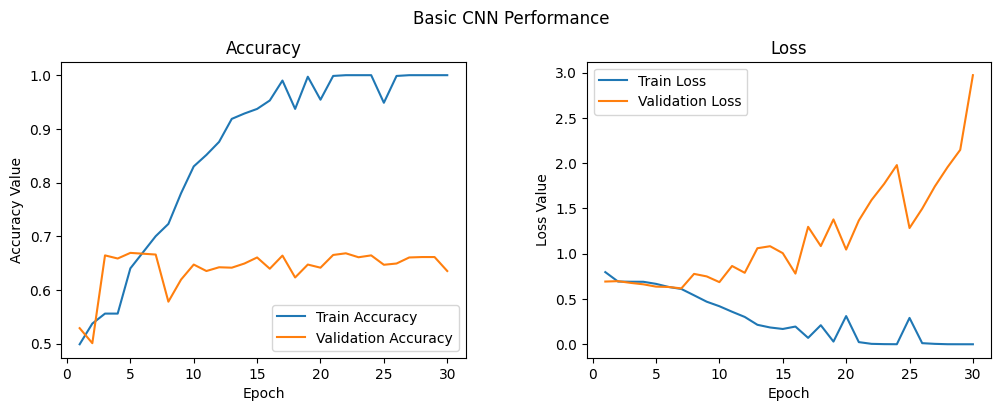

In [19]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Basic CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,31))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 31, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 31, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

Accuracy and Loss between training and validation are diverging.  This is a distinct sign of overfitting as the model is able to "generalize" enough to properly identify an unseen image.

# Regularization of CNN models

Regularization methods help prevent a problem called overfitting when training Convolutional Neural Networks (CNNs). Overfitting happens when a model learns the training data too well, including all the tiny details and noise, so it doesn’t work well on new, unseen data. It's like memorizing answers for a test without understanding the subject.
Two common regularization methods are called L1 and L2 regularization. They are also known as lasso (L1) and ridge (L2) regularization, or sometimes just weight decay. These methods work by adding an extra term to the model’s loss function, which is what the model tries to minimize while learning. This extra term looks at the size of the weights in the model and tries to keep them from getting too large.
L1 regularization (lasso) encourages the model to make some of its weights exactly zero. This means the model ignores some features completely, which can make it simpler and help prevent overfitting. L2 regularization (ridge) doesn’t make weights zero, but it makes all the weights smaller overall. Both methods help the model focus on the most important patterns in the data, instead of just memorizing everything, which helps it do better on new data.


Dropout is a technique that randomly drops out some units or neurons in the hidden layers during training, preventing co-adaptation (strong correlation) of features. This helps the model learn from different perspectives and variations of the data. Dropout works by randomly turning off 30% of the units (or neurons) in our dense layers during each training step. When a unit is turned off, its output is set to zero, meaning it doesn't contribute to the next layer for that particular step. This process helps the model learn more robust features and prevents it from relying too much on any single unit, ultimately improving its ability to generalize to new data.

In [20]:
model = Sequential()

model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', 
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))


model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(),
              metrics=['accuracy'])
              
              
history = model.fit(x=train_imgs_scaled, y=train_labels_enc,
                    validation_data=(validation_imgs_scaled, validation_labels_enc),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1) 

Epoch 1/30
Params set by AI: DeviceGroupedConvFwdMultipleABD_Xdl_CShuffle<256, 128, 64, 16, Default, 32, 32, 2, 1, 4, 4, 4, 1, 1, 1>
21/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5189 - loss: 0.7199Params set by AI: DeviceGroupedConvFwdMultipleABD_Xdl_CShuffle<256, 128, 64, 16, OddC, 32, 32, 2, 1, 4, 4, 4, 1, 1, 1>
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 0.5182 - loss: 0.7181Params set by AI: DeviceGroupedConvFwdMultipleABD_Xdl_CShuffle<256, 128, 64, 16, OddC, 32, 32, 2, 1, 4, 4, 4, 1, 1, 1>
24/24 ━━━━━━━━━━━━━━━━━━━━ 12s 309ms/step - accuracy: 0.5181 - loss: 0.7175 - val_accuracy: 0.5006 - val_loss: 0.6952
Epoch 2/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5110 - loss: 0.6938 - val_accuracy: 0.5006 - val_loss: 0.6931
Epoch 3/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4930 - loss: 0.6941 - val_accuracy: 0.5006 - val_loss: 0.6927
Epoch 4/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5008 - loss: 0.6951 - val_accuracy: 0.5006 - v

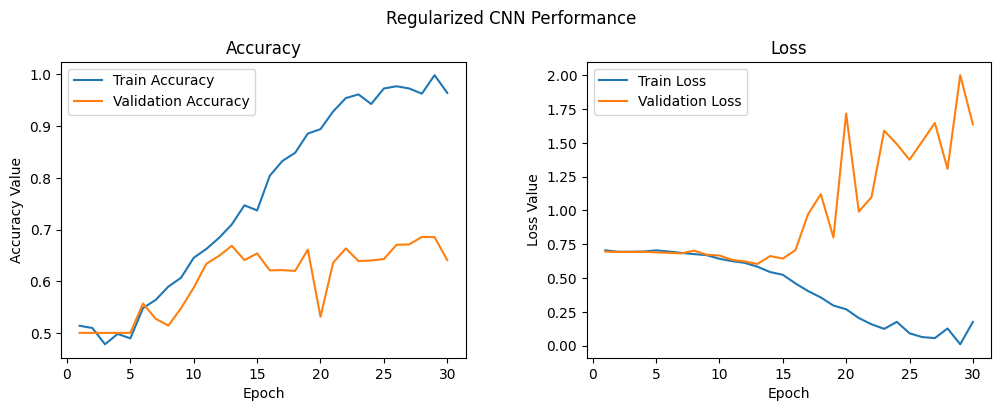

In [21]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Regularized CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,31))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 31, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 31, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

Overfitting happens when a model learns the training data too well but doesn’t do well on new, unseen data. You can spot overfitting when the training loss keeps getting lower, but the validation loss starts to get higher. This means the model is not able to generalize and make good predictions on data it hasn’t seen before.

## CNN Model with Image Augmentation

When you use image augmentation in a CNN model, the computer creates new, slightly changed versions of your training images by randomly flipping, rotating, cropping, or changing the brightness and contrast of the originals. This helps the model see more variety in the data, making it less likely to memorize just the training images and more likely to recognize new images correctly. As a result, image augmentation can help reduce overfitting and improve the model’s ability to generalize to new, unseen data.

The code below creates two image data generators: one for training data with various augmentations (rescaling, zoom, rotation, shifts, shear, flip) and one for validation data with rescaling only.

In [22]:
train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, rotation_range=50,
                                   width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, 
                                   horizontal_flip=True, fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)

Next, the code generates and displays five augmented versions of a specific training image, along with their labels, using the previously defined image data generator. We do this for cats and dog image.

Labels: ['cat', 'cat', 'cat', 'cat', 'cat']


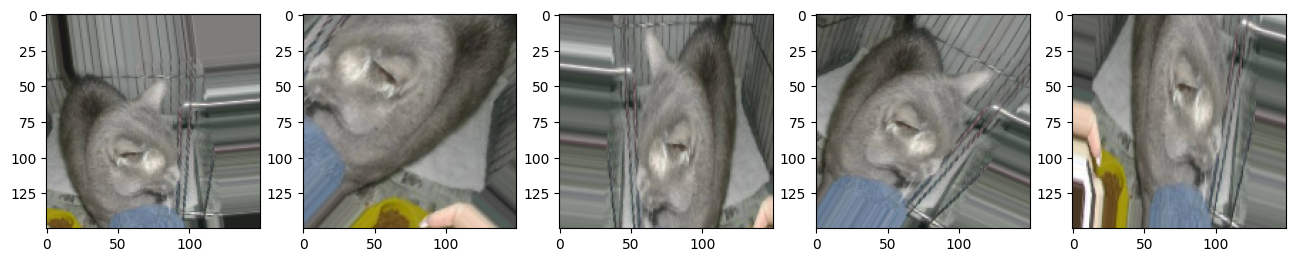

In [23]:
img_id = 15
cat_generator = train_datagen.flow(train_imgs[img_id:img_id+1], train_labels[img_id:img_id+1],
                                   batch_size=1)
cat = [next(cat_generator) for i in range(0,5)]
#print(cat[0])
fig, ax = plt.subplots(1,5, figsize=(16, 6))
print('Labels:', [item[1][0] for item in cat])
l = [ax[i].imshow(cat[i][0][0]) for i in range(0,5)]

Labels: ['dog', 'dog', 'dog', 'dog', 'dog']


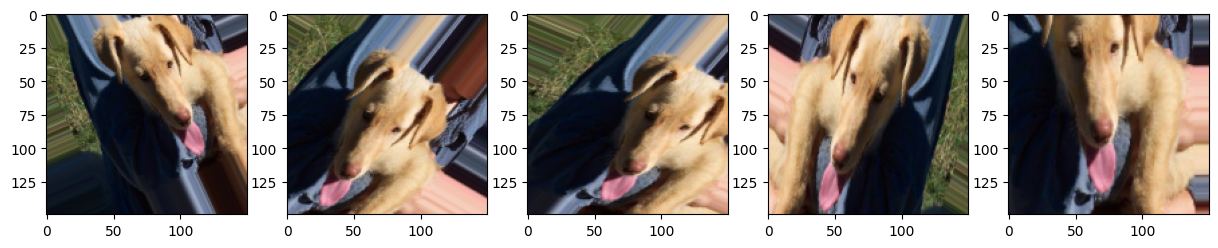

In [24]:
img_id = 350
dog_generator = train_datagen.flow(train_imgs[img_id:img_id+1], train_labels[img_id:img_id+1],
                                   batch_size=1)
dog = [next(dog_generator) for i in range(0,5)]
fig, ax = plt.subplots(1,5, figsize=(15, 6))
print('Labels:', [item[1][0] for item in dog])
l = [ax[i].imshow(dog[i][0][0]) for i in range(0,5)]

Next, we create two data generators: one for training data with a batch size of 25 and one for validation data with a batch size of 20, and sets the input shape for the images to 150x150 pixels with 3 color channels.

In [25]:
train_generator = train_datagen.flow(train_imgs, train_labels_enc, batch_size=25)
val_generator = val_datagen.flow(validation_imgs, validation_labels_enc, batch_size=20)

input_shape = (150, 150, 3)

We build the model with the augmented images generated above.

In [26]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.models import Sequential
from keras import optimizers

model = Sequential()

model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', 
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))


model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 148, 148, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 74, 74, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 72, 72, 64)     │         9,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 512)            │     3,211,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,706,113 (14.14 MB)

 Trainable params: 3,706,113 (14.14 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
#history = model.fit(train_generator, steps_per_epoch=50, epochs=50, validation_data=val_generator, validation_steps=50, verbose=1)
history = model.fit(train_generator, epochs=70, validation_data=val_generator, validation_steps=70, verbose=1)

Epoch 1/70
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 111ms/step - accuracy: 0.5371 - loss: 0.6956 - val_accuracy: 0.5343 - val_loss: 0.6922
Epoch 2/70
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.4610 - loss: 0.6956 - val_accuracy: 0.5057 - val_loss: 0.6908
Epoch 3/70
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.5185 - loss: 0.6935 - val_accuracy: 0.5721 - val_loss: 0.6903
Epoch 4/70
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.5417 - loss: 0.6935 - val_accuracy: 0.5957 - val_loss: 0.6910
Epoch 5/70
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.4659 - loss: 0.6951 - val_accuracy: 0.4907 - val_loss: 0.6919
Epoch 6/70
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.5236 - loss: 0.6893 - val_accuracy: 0.5993 - val_loss: 0.6893
Epoch 7/70
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.5247 - loss: 0.6906 - val_accuracy: 0.5171 - val_loss: 0.6889
Epoch 8/70
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.5462 - loss: 0.6865 - val_accuracy: 0.5071 - 

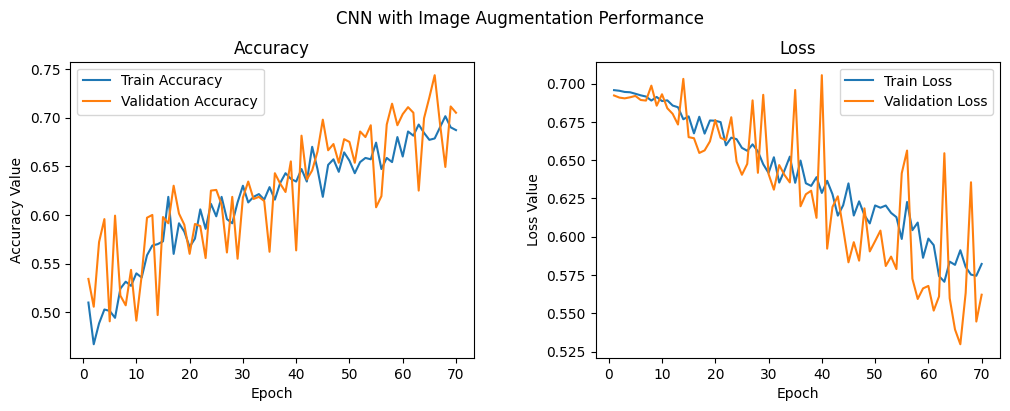

In [28]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('CNN with Image Augmentation Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,71))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 71, 10))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 71, 10))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

We notice that validation accuracy trends much closer to training accuracy.  The two aren't diverging as evident without image augmentation.  The indicates that there is less overfitting and we have a model that generalizes much better as compared to our previous models. The choppy nature of the validation loss curve often signals that the model is struggling to consistently perform well on new, unseen data so the model might not be generalizing well to new data, possibly because the augmented images in validation don't represent what the model was trained to respresent.

Next, we save the model

In [29]:
# model is saved
model.save('cats_dogs_basic.h5')

# VGG-16 Pre-trained model


VGG-16 is a model that was already trained on a very large dataset (ImageNet) with many different types of images. It learned important patterns or "features" from the images in a way that doesn't change if the image is moved, or parts of it are in different positions.<br>
Since VGG-16 was trained on over a million image from 1000 categories, it understands what make images different in a good way. Even if new images are totally new and not in ImageNet, VGG-16 can still pick out important parts of the new images that help describe what is in them.<br>
Because VGG-16 learned such good features from lots of data, we can use it to extract or pick out features from new images, even if they are different categories. This makes VGG-16 useful for computer vision problems on new, unseen images too.

Using Keras, we will load the VGG-16 model, and freeze the convolution blocks so that we can use it as just an image feature extractor.

In [30]:
from keras.applications import vgg16
from keras.models import Model
import keras

vgg = vgg16.VGG16(include_top=False, weights='imagenet', 
                                     input_shape=input_shape)

output = vgg.layers[-1].output
output = keras.layers.Flatten()(output)
vgg_model = Model(vgg.input, output)

vgg_model.trainable = False
for layer in vgg_model.layers:
    layer.trainable = False
    
import pandas as pd
pd.set_option('max_colwidth', None)
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable']) 

,Layer Type,Layer Name,Layer Trainable
0,"<InputLayer name=input_layer_3, built=True>",input_layer_3,False
1,"<Conv2D name=block1_conv1, built=True>",block1_conv1,False
2,"<Conv2D name=block1_conv2, built=True>",block1_conv2,False
3,"<MaxPooling2D name=block1_pool, built=True>",block1_pool,False
4,"<Conv2D name=block2_conv1, built=True>",block2_conv1,False
5,"<Conv2D name=block2_conv2, built=True>",block2_conv2,False
6,"<MaxPooling2D name=block2_pool, built=True>",block2_pool,False
7,"<Conv2D name=block3_conv1, built=True>",block3_conv1,False
8,"<Conv2D name=block3_conv2, built=True>",block3_conv2,False
9,"<Conv2D name=block3_conv3, built=True>",block3_conv3,False


We see that none of the layers are trainable (shown by False).  This is the result we want since we want VGG-16 to keep the features it already learned from ImageNet.  "block5_pool" are the bottleneck features as they are located right before the classification head of the network, so their outputs contain highly discriminative features for the original classification task. Discriminative features are the special parts or characteristics of something (like an image or a piece of data) that help you tell the difference between different groups or categories. For example, if you are trying to tell the difference between cats and dogs, things like "pointy ears" or "whiskers" could be discriminative features because they help you decide which animal you are looking at. In machine learning, finding good discriminative features helps computers sort or classify things more accurately and quickly,

The following cell shows what the bottleneck features look like for a random sample image from our training data.

In image models such as the ones we are developing here, <b>bottleneck features</b> are usually taken from the last convolutional layer before the fully connected layers, capturing key patterns and details in a compact form.
These features are especially useful in transfer learning. Instead of training a whole new model, you can use a pre-trained network to extract bottleneck features from your images, then train a smaller model on top of these features for your specific task. This saves time and computational resources while still using the powerful representations learned by large networks.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
(1, 4, 4, 512)


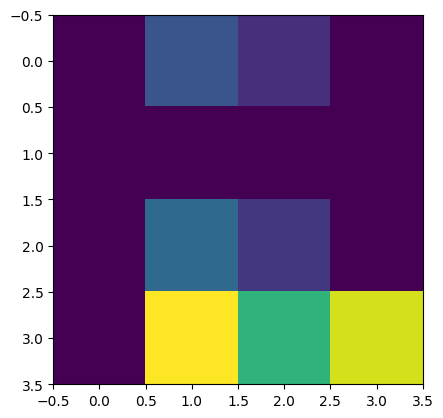

In [31]:
bottleneck_feature_example = vgg.predict(train_imgs_scaled[0:1])
print(bottleneck_feature_example.shape)
plt.imshow(bottleneck_feature_example[0][:,:,0])

In [32]:
def get_bottleneck_features(model, input_imgs):
    features = model.predict(input_imgs, verbose=0)
    return features
    
train_features_vgg = get_bottleneck_features(vgg_model, train_imgs_scaled)
validation_features_vgg = get_bottleneck_features(vgg_model, validation_imgs_scaled)

print('Train Bottleneck Features:', train_features_vgg.shape, 
      '\tValidation Bottleneck Features:', validation_features_vgg.shape)

Params set by AI: DeviceGroupedConvFwdMultipleABD_Xdl_CShuffle<256, 128, 128, 16, OddC, 32, 32, 2, 2, 1, 1, 4, 1, 1, 1>
Params set by AI: DeviceGroupedConvFwdMultipleABD_Xdl_CShuffle<256, 128, 64, 16, OddC, 32, 32, 2, 1, 4, 4, 4, 1, 1, 1>
Params set by AI: DeviceGroupedConvFwdMultipleABD_Xdl_CShuffle<256, 64, 128, 16, OddC, 32, 32, 1, 2, 4, 4, 4, 1, 1, 1>
Params set by AI: DeviceGroupedConvFwdMultipleABD_Xdl_CShuffle<256, 128, 64, 16, OddC, 32, 32, 2, 1, 4, 4, 4, 1, 1, 1>
Params set by AI: DeviceGroupedConvFwdMultipleABD_Xdl_CShuffle<256, 128, 64, 16, OddC, 32, 32, 2, 1, 4, 4, 4, 1, 1, 1>
Params set by AI: DeviceGroupedConvFwdMultipleABD_Xdl_CShuffle<256, 128, 64, 16, OddC, 32, 32, 2, 1, 4, 4, 4, 1, 1, 1>
Params set by AI: DeviceGroupedConvFwdMultipleABD_Xdl_CShuffle<256, 128, 64, 16, OddC, 32, 32, 2, 1, 4, 4, 4, 1, 1, 1>
Params set by AI: DeviceGroupedConvFwdMultipleABD_Xdl_CShuffle<64, 64, 32, 16, Default, 32, 32, 2, 1, 4, 4, 1, 1, 1, 1>
Params set by AI: DeviceGroupedConvFwdMultiple

The output of the code above confirms we have extracted the bottleneck features.<br>
Now let's build the model based on those features.

In [33]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers

input_shape = vgg_model.output_shape[1]

model = Sequential()
model.add(InputLayer(input_shape=(input_shape,)))
model.add(Dense(512, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['accuracy'])

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,457,985 (17.01 MB)

 Trainable params: 4,457,985 (17.01 MB)

 Non-trainable params: 0 (0.00 B)

In [34]:
history = model.fit(x=train_features_vgg, y=train_labels_enc,
                    validation_data=(validation_features_vgg, validation_labels_enc),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1)

Epoch 1/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 0.6504 - loss: 0.6490 - val_accuracy: 0.8317 - val_loss: 0.4053
Epoch 2/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8165 - loss: 0.4201 - val_accuracy: 0.8457 - val_loss: 0.3449
Epoch 3/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8317 - loss: 0.3727 - val_accuracy: 0.8364 - val_loss: 0.3591
Epoch 4/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9092 - loss: 0.2727 - val_accuracy: 0.8422 - val_loss: 0.3390
Epoch 5/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9289 - loss: 0.2029 - val_accuracy: 0.8686 - val_loss: 0.3014
Epoch 6/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9203 - loss: 0.1959 - val_accuracy: 0.8480 - val_loss: 0.3517
Epoch 7/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9333 - loss: 0.1800 - val_accuracy: 0.8651 - val_loss: 0.3011
Epoch 8/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9666 - loss: 0.1084 - val_accuracy: 0.7629 - val_los

In [35]:
model.save('cats_dogs_vgg16.h5')

Let's evaluate the performance

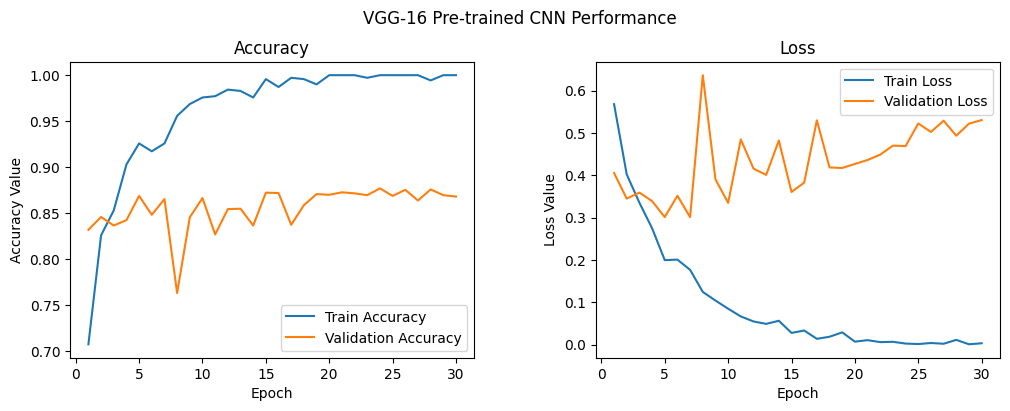

In [36]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('VGG-16 Pre-trained CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,31))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 31, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 31, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

We get a validation accuracy in the higher 80s. That over 20% increase over the basic model with the raw data. The gap between training and validation is fairly large which tells us there could still be a significant amount of overfitting on the training data.  Overall, it's a very good result.

### Pre-trained CNN model as a Feature Extractor with Image Augmentation

Let's recap as we move into the final stages of developing a good model.
VGG-16 has already learned to recognize important visual patterns from millions of images in the ImageNet dataset, such as edges, shapes, and textures. By using its pre-trained weights, we apply this knowledge to our own task, even with a much smaller dataset. This saved time, reduced the need for large amounts of data, and led to better results than training a model from scratch.
We want to use Image Augmentation to further improve our model by creating many new, slightly different versions of your training images (through flipping, rotating, cropping, etc.). This increases the variety of data the model sees, helping it learn to ignore irrelevant details and better generalize to new, unseen images. Together, transfer learning with VGG-16 and image augmentation should help build a model that is both accurate and robust, even with limited training data.

In [37]:
train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, rotation_range=50,
                                   width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, 
                                   horizontal_flip=True, fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(train_imgs, train_labels_enc, batch_size=30)
val_generator = val_datagen.flow(validation_imgs, validation_labels_enc, batch_size=20)

As explained with Regularization of CNN models at the begining of the tutorial, dropout is a technique that randomly drops out some units or neurons in the hidden layers during training, preventing co-adaptation (strong correlation) of features. This helps the model learn from different perspectives and variations of the data.
In our example, Dropout randomly masks the outputs of a fraction of units from a layer by setting their output to zero (it is 30% of the units in our dense layers).


In [38]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers

model = Sequential()
model.add(vgg_model)
model.add(Dense(512, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=2e-5),
              metrics=['accuracy'])
              
history = model.fit(train_generator, steps_per_epoch=70, epochs=70,
                              validation_data=val_generator, validation_steps=70, 
                              verbose=1) 

Epoch 1/70
70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - accuracy: 0.5660 - loss: 0.6993 - val_accuracy: 0.6550 - val_loss: 0.6268
Epoch 2/70
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.6168 - loss: 0.6526 - val_accuracy: 0.7136 - val_loss: 0.5872
Epoch 3/70
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.6598 - loss: 0.6263 - val_accuracy: 0.7893 - val_loss: 0.5407
Epoch 4/70
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.6523 - loss: 0.6142 - val_accuracy: 0.7721 - val_loss: 0.5207
Epoch 5/70
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.6841 - loss: 0.5827 - val_accuracy: 0.8071 - val_loss: 0.4799
Epoch 6/70
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.7159 - loss: 0.5631 - val_accuracy: 0.8300 - val_loss: 0.4590
Epoch 7/70
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.7176 - loss: 0.5521 - val_accuracy: 0.7971 - val_loss: 0.4496
Epoch 8/70
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.7268 - loss: 0.5370 - val_accuracy: 0.8136 - v

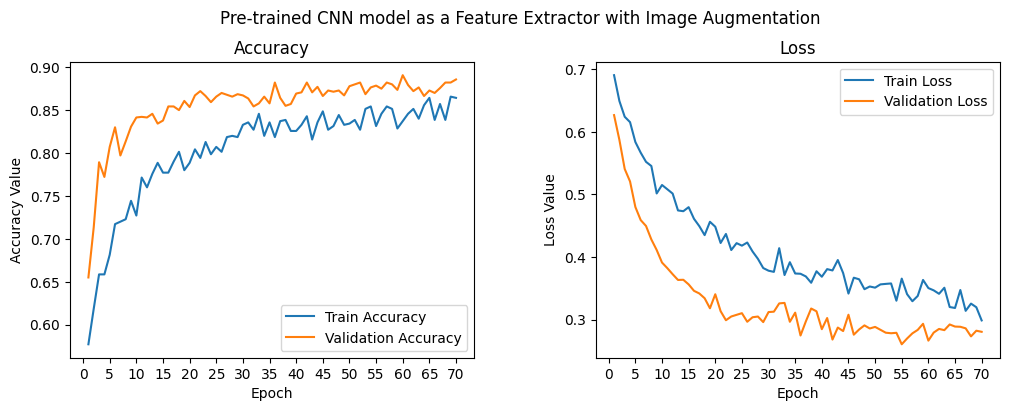

In [39]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Pre-trained CNN model as a Feature Extractor with Image Augmentation', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,71))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 71, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 71, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

### Pre-trained CNN model with Fine-tuning and Image Augmentation

When building an image classifier, you can use a pre-trained CNN model like VGG-16, which has already learned a lot about images from a huge dataset. By fine-tuning, you adjust the last layers of this model to better fit your own images, so you don’t have to start from scratch. Adding image augmentation means you make lots of new, slightly different versions of your training pictures, like flipping or rotating them, so your model gets better at recognizing new images. Using both fine-tuning and image augmentation helps you create a strong, accurate model, even if you don’t have a lot of data to start with.

In [40]:
vgg_model.trainable = True

set_trainable = False
for layer in vgg_model.layers:
    if layer.name in ['block5_conv1', 'block4_conv1']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
        
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable']) 

,Layer Type,Layer Name,Layer Trainable
0,"<InputLayer name=input_layer_3, built=True>",input_layer_3,False
1,"<Conv2D name=block1_conv1, built=True>",block1_conv1,False
2,"<Conv2D name=block1_conv2, built=True>",block1_conv2,False
3,"<MaxPooling2D name=block1_pool, built=True>",block1_pool,False
4,"<Conv2D name=block2_conv1, built=True>",block2_conv1,False
5,"<Conv2D name=block2_conv2, built=True>",block2_conv2,False
6,"<MaxPooling2D name=block2_pool, built=True>",block2_pool,False
7,"<Conv2D name=block3_conv1, built=True>",block3_conv1,False
8,"<Conv2D name=block3_conv2, built=True>",block3_conv2,False
9,"<Conv2D name=block3_conv3, built=True>",block3_conv3,False


Note how we made blocks 4 and 5 trainable.  This allows us to introduce the augmented images.

In [41]:
tf.keras.backend.clear_session()

In [42]:
train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, rotation_range=50,
                                   width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, 
                                   horizontal_flip=True, fill_mode='nearest')
val_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow(train_imgs, train_labels_enc, batch_size=30)
val_generator = val_datagen.flow(validation_imgs, validation_labels_enc, batch_size=20)

from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers

model = Sequential()
model.add(vgg_model)
model.add(Dense(512, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-5),
              metrics=['accuracy'])
           

history = model.fit(train_generator, steps_per_epoch=70, epochs=70,
                              validation_data=val_generator, validation_steps=70, 
                              verbose=1)

Epoch 1/70
70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - accuracy: 0.5206 - loss: 0.7218 - val_accuracy: 0.6507 - val_loss: 0.6516
Epoch 2/70
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.5810 - loss: 0.6598 - val_accuracy: 0.7350 - val_loss: 0.5795
Epoch 3/70
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.6667 - loss: 0.6207 - val_accuracy: 0.8393 - val_loss: 0.4625
Epoch 4/70
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.6994 - loss: 0.5710 - val_accuracy: 0.8629 - val_loss: 0.3894
Epoch 5/70
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.7733 - loss: 0.5009 - val_accuracy: 0.8593 - val_loss: 0.3469
Epoch 6/70
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.7827 - loss: 0.4903 - val_accuracy: 0.8486 - val_loss: 0.3530
Epoch 7/70
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.8056 - loss: 0.4240 - val_accuracy: 0.8579 - val_loss: 0.3241
Epoch 8/70
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.8036 - loss: 0.4195 - val_accuracy: 0.8836 - v

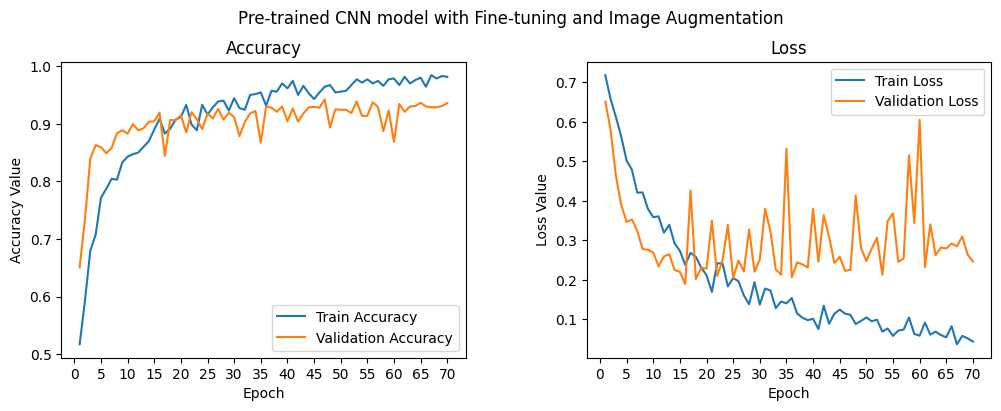

In [43]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Pre-trained CNN model with Fine-tuning and Image Augmentation', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,71))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 71, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 71, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

The performance improvement using VGG pre-trained model is notable. The validation accuracy went from 89% with simple image augmentation to 94% with fine-tuning and image augmentation. This is a significant increase from the 68% we achieved at the beginning of the workshop with the basic CNN model.